In [1]:
import os
from ast import literal_eval
import pandas as pd
import numpy as np
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima_model import ARIMA
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import warnings
warnings.filterwarnings('ignore')

## Data

In [3]:
train_dfs, test_dfs = {}, {}
states = []
train_path = '../data/state_flu_google/train/'
test_path = '../data/state_flu_google/test/'

for root,dirs,files in os.walk(train_path):
    for file in files:
        if file.endswith('csv'):
            state = file[:-4]
            states.append(state)
            train_dfs[state] = pd.read_csv(train_path + file)

for root,dirs,files in os.walk(test_path):
    for file in files:
        if file.endswith('csv'):
            state = file[:-4]
            test_dfs[state] = pd.read_csv(test_path + file)

In [81]:
def normalize_google_trend(google_df):
    for col in google_df.columns: 
        google_df[col] = (google_df[col]-google_df[col].min())/(google_df[col].max()-google_df[col].min())
    return google_df

## Model

### Baseline

In [4]:
def baseline(state):
    # Use the most recent observation to predict future weeks
    flu_train, flu_test = train_dfs[state].iloc[:, 1], test_dfs[state].iloc[:, 1]
    preds = [flu_train.iloc[-1]]*len(flu_test)     
    return np.sqrt(mean_squared_error(flu_test, preds))

In [5]:
baseline('Texas')

4.274130687195383

In [6]:
baseline('New York')

2.4671586642026044

### Persistence

In [127]:
def persistence(state, if_plot=True):
    train, test = train_dfs[state], test_dfs[state]
    
    # model and predict
    preds = test.iloc[:,1]
    y_test = test.target
    rmse = np.sqrt(mean_squared_error(y_test, preds))

    if if_plot:
        plt.figure(figsize = [15, 6])
        plt.plot(y_test, label='true')
        plt.plot(preds, label='predicted')
        plt.legend()
        plt.show()
    
    return rmse

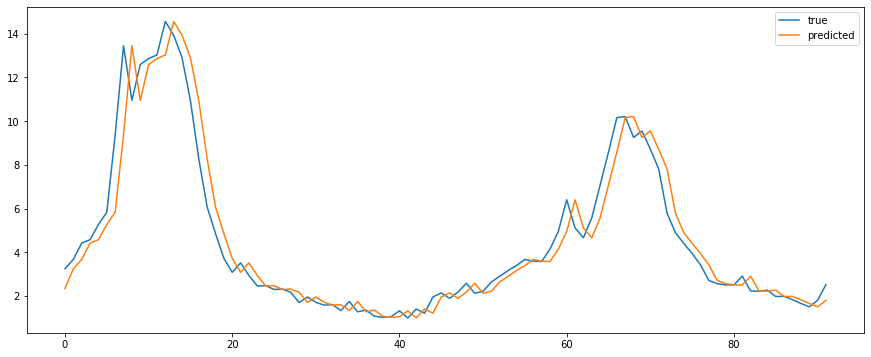

0.9884152065507495

In [128]:
persistence('Texas')

In [129]:
persistence('New York', if_plot = False)

0.6526867781791826

### Linear Autoregression

In [13]:
def auto_regression(state, with_gt=False, if_plot=True):
    # prepare the data
    train, test = train_dfs[state], test_dfs[state]
    X_train, X_test = pd.DataFrame(train.iloc[:, 1]), pd.DataFrame(test.iloc[:, 1]) # flu data
    y_train, y_test = train.target, test.target
    
    # get autoregressive terms
    for i in range(52): # 52 lags to cover the whole year
        X_train['lag {}'.format(i+1)] = X_train.iloc[:, 0].shift(i+1)
        train_na = X_train['lag {}'.format(i+1)][X_train['lag {}'.format(i+1)].notna()].iloc[0]
        X_train['lag {}'.format(i+1)] = X_train['lag {}'.format(i+1)].fillna(train_na)
        
        X_test['lag {}'.format(i+1)] = X_test.iloc[:, 0].shift(i+1)
        test_na = X_test['lag {}'.format(i+1)][X_test['lag {}'.format(i+1)].notna()].iloc[0]
        X_test['lag {}'.format(i+1)] = X_test['lag {}'.format(i+1)].fillna(test_na)
        
    model = LinearRegression().fit(X_train, y_train)
    preds = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, preds))

    if with_gt:
        X_train_gt, X_test_gt = train.iloc[:, 2:-1], test.iloc[:, 2:-1] # google trend data
#         X_train_gt = normalize_google_trend(X_train_gt).fillna(0)
#         X_test_gt = normalize_google_trend(X_test_gt).fillna(0)
        
        X_train, X_test = pd.concat([X_train, X_train_gt], axis = 1), pd.concat([X_test, X_test_gt], axis = 1)

        lasso = Lasso()
        parameters = {'alpha':[.1, .01, .001, .0001, .00001]}
        model = GridSearchCV(lasso, parameters, cv=4).fit(X_train, y_train)
        preds = model.predict(X_test)
        rmse = np.sqrt(mean_squared_error(y_test, preds))

    # plot
    if if_plot:
        plt.figure(figsize = [15, 6])
        plt.plot(y_test, label='true')
        plt.plot(preds, label='predicted')
        plt.legend()
        plt.show()    
    
    return rmse

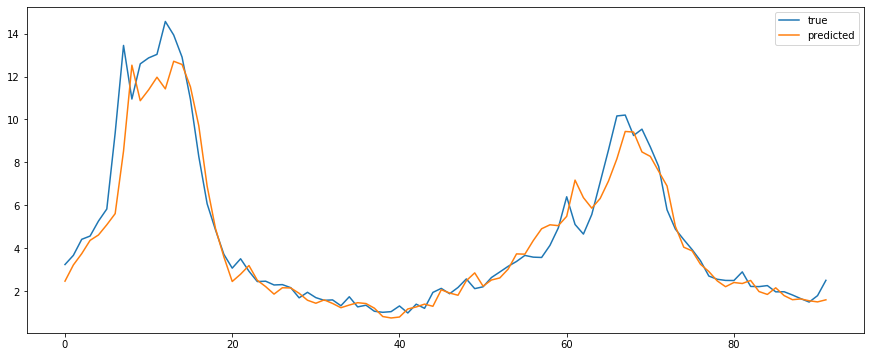

0.9922520974460209

In [25]:
# without google trend
auto_regression('Texas', with_gt = False)

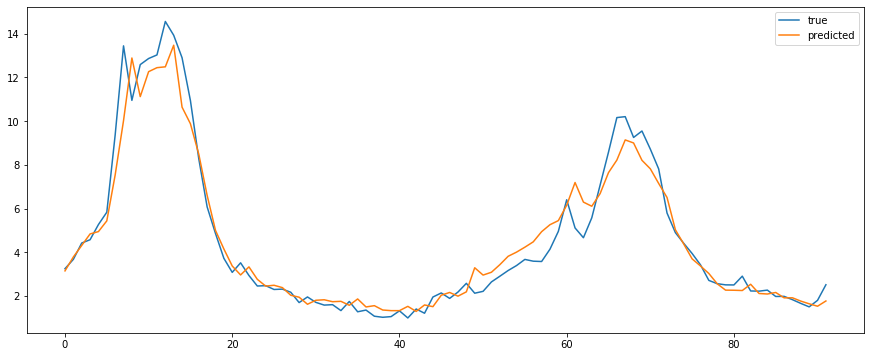

0.8231648068585198

In [26]:
# with google trend
auto_regression('Texas', with_gt = True)

In [23]:
# without google trend
auto_regression('New York', with_gt=False, if_plot=False)

0.6191520386015095

In [24]:
# with google trend
auto_regression('New York', with_gt=True, if_plot=False)

1.4710549674572224

### Linear Network Autoregression

In [87]:
def lnar(target_state, predictor_state, with_gt=False, if_plot=True):
    # get train test
    train, test = train_dfs[target_state], test_dfs[target_state]
    y_train, y_test = train.target, test.target
    
    X_train, X_test = pd.DataFrame(train.iloc[:, 1]), pd.DataFrame(test.iloc[:, 1]) # flu data
    for p in predictor_state:
        X_train[p] = train_dfs[p].iloc[:, 1]
        X_test[p] = test_dfs[p].iloc[:, 1]
    
    # get autoregressive terms
    for i in range(52):
        for col in predictor_state:
            X_train['{} lag {}'.format(col, i+1)] = X_train[col].shift(i+1)
            na = X_train['{} lag {}'.format(col, i+1)][X_train['{} lag {}'.format(col, i+1)].notna()].iloc[0]
            X_train['{} lag {}'.format(col, i+1)] = X_train['{} lag {}'.format(col, i+1)].fillna(na)
            
            X_test['{} lag {}'.format(col, i+1)] = X_test[col].shift(i+1)
            na = X_test['{} lag {}'.format(col, i+1)][X_test['{} lag {}'.format(col, i+1)].notna()].iloc[0]
            X_test['{} lag {}'.format(col, i+1)] = X_test['{} lag {}'.format(col, i+1)].fillna(na)
            
    model = LinearRegression().fit(X_train, y_train)
    pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, pred))
    
    if with_gt: 
        gt_train, gt_test = [], []  
        for p in predictor_state:
            gt_train.append(train_dfs[p].iloc[:, 2:-1])
            gt_test.append(test_dfs[p].iloc[:, 2:-1])
        gt_train, gt_test = pd.concat(gt_train, axis = 1), pd.concat(gt_test, axis = 1)

        X_train, X_test = pd.concat([X_train, gt_train], axis=1), pd.concat([X_test, gt_test], axis=1)
           
        lasso = Lasso()
        parameters = {'alpha':[.1, .01, .001, .0001, .00001]}
        model = GridSearchCV(lasso, parameters, cv=4).fit(X_train, y_train)
        preds = model.predict(X_test)
        rmse = np.sqrt(mean_squared_error(y_test, preds))

    if if_plot:
        plt.figure(figsize = [15, 6])
        plt.plot(y_test.tolist(), label='true')
        plt.plot(pred, label='predicted')
        plt.legend()
        plt.show() 
        
    return rmse

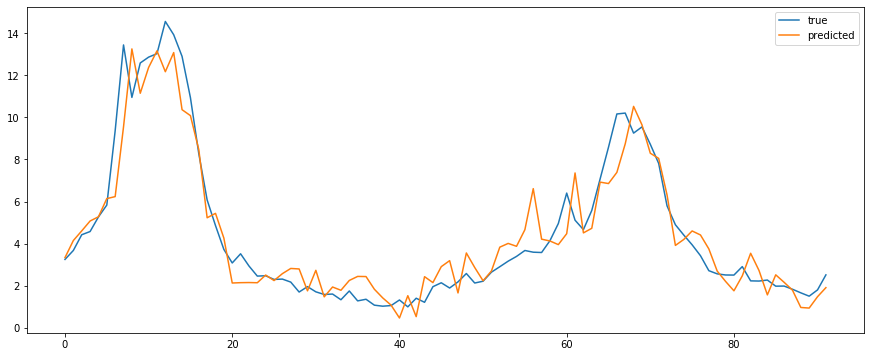

1.1035479583648498

In [88]:
# Use surrounding states as predictors
# without google trend
lnar('Texas', ['New Mexico', 'Oklahoma', 'Louisiana', 'Arkansas'])

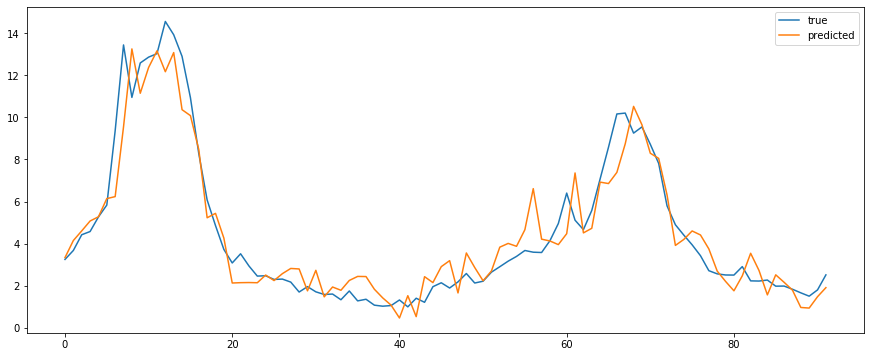

1.2987241197918338

In [90]:
lnar('Texas', ['New Mexico', 'Oklahoma', 'Louisiana', 'Arkansas'], with_gt=True)

In [91]:
# With Google Trend
lnar('New York', ['Pennsylvania', 'New Jersey', 'Connecticut', 'Massachusetts', 'Vermont'], if_plot=False)

1.3562382056708775

In [92]:
# Without google trend
lnar('New York', ['Pennsylvania', 'New Jersey', 'Connecticut', 'Massachusetts', 'Vermont'], with_gt=True, if_plot=False)

1.060227507813953

### Random Forest

In [102]:
def random_forest(target_state, predictor_state, with_gt = False, if_plot = True):
    # get train test
    train, test = train_dfs[target_state], test_dfs[target_state]
    y_train, y_test = train.target, test.target
    
    X_train, X_test = pd.DataFrame(train.iloc[:, 1]), pd.DataFrame(test.iloc[:, 1]) # flu data
    for p in predictor_state:
        X_train[p] = train_dfs[p].iloc[:, 1]
        X_test[p] = test_dfs[p].iloc[:, 1]
    
    # get autoregressive terms
    for i in range(52):
        for col in predictor_state:
            X_train['{} lag {}'.format(col, i+1)] = X_train[col].shift(i+1)
            na = X_train['{} lag {}'.format(col, i+1)][X_train['{} lag {}'.format(col, i+1)].notna()].iloc[0]
            X_train['{} lag {}'.format(col, i+1)] = X_train['{} lag {}'.format(col, i+1)].fillna(na)
            
            X_test['{} lag {}'.format(col, i+1)] = X_test[col].shift(i+1)
            na = X_test['{} lag {}'.format(col, i+1)][X_test['{} lag {}'.format(col, i+1)].notna()].iloc[0]
            X_test['{} lag {}'.format(col, i+1)] = X_test['{} lag {}'.format(col, i+1)].fillna(na)
   
    if with_gt:
        gt_train, gt_test = [], []  
        for p in predictor_state:
            gt_train.append(train_dfs[p].iloc[:, 2:-1])
            gt_test.append(test_dfs[p].iloc[:, 2:-1])
        gt_train, gt_test = pd.concat(gt_train, axis = 1), pd.concat(gt_test, axis = 1)

        X_train, X_test = pd.concat([X_train, gt_train], axis=1), pd.concat([X_test, gt_test], axis=1)
    
    rf = RandomForestRegressor(n_estimators=50, random_state=0)
    parameters = {'max_depth':[2, 4, 8, 16]}
    model = GridSearchCV(rf, parameters, cv=4).fit(X_train, y_train)
    pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, pred))
    
    if if_plot:
        plt.figure(figsize = [15, 6])
        plt.plot(y_test.tolist(), label='true')
        plt.plot(pred, label='predicted')
        plt.legend()
        plt.show() 
    
    return rmse

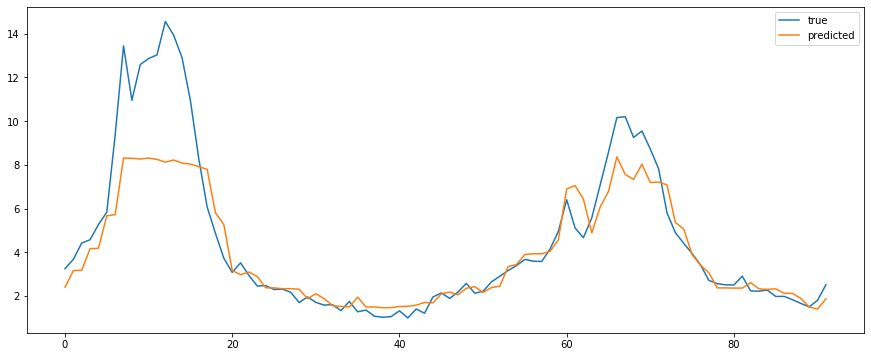

1.6932972823554704

In [103]:
# without GT
random_forest('Texas', ['New Mexico', 'Oklahoma', 'Louisiana', 'Arkansas'])

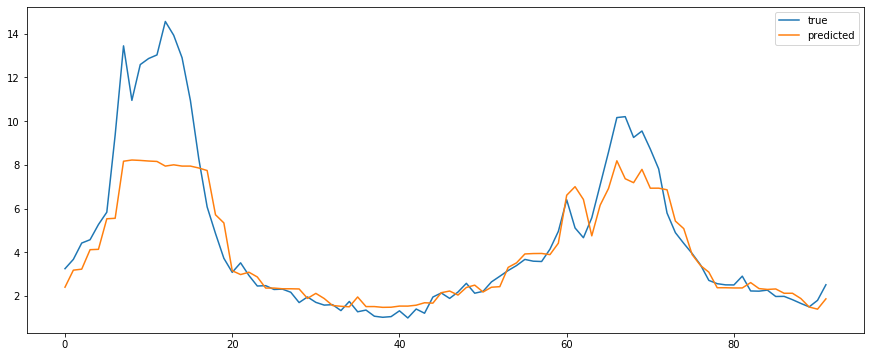

1.7446184180854054

In [95]:
# with GT
random_forest('Texas', ['New Mexico', 'Oklahoma', 'Louisiana', 'Arkansas'], with_gt=True)

In [96]:
# without GT
random_forest('New York', ['Pennsylvania', 'New Jersey', 'Connecticut', 'Massachusetts', 'Vermont'], if_plot=False)

1.4818067587023678

In [97]:
# with GT
random_forest('New York', ['Pennsylvania', 'New Jersey', 'Connecticut', 'Massachusetts', 'Vermont'], with_gt = True, if_plot=False)

1.479508978000272

### Run the models and record RMSE

#### Baseline

In [104]:
baseline_rmse = []
for state in states:
    baseline_rmse.append(baseline(state))

#### persistence

In [130]:
persistence_rmse = []
for state in states:
    persistence_rmse.append(persistence(state, if_plot=False))

#### Linear Autoregression

In [105]:
# without google trend
ar_rmse = []
for state in states:
    ar_rmse.append(auto_regression(state, with_gt=False, if_plot=False))

In [106]:
# with google trend
argt_rmse = []
for state in states:
    argt_rmse.append(auto_regression(state, with_gt=True, if_plot=False))

#### Linear Network Autoregression

In [107]:
neighbors = pd.read_csv('../data/state_neighbors.csv').set_index('state')
neighbors['neigh_state'] = neighbors['neigh_state'].apply(literal_eval)
neighbors.head()

,neigh_state
state,
Alabama,"[Georgia, Mississippi, Tennessee]"
Alaska,[Washington]
Arizona,"[California, Colorado, New Mexico, Nevada, Utah]"
Arkansas,"[Louisiana, Missouri, Mississippi, Oklahoma, T..."
California,"[Hawaii, Nevada, Oregon]"


In [108]:
# without google trend
lar_rmse = []
for state in states:
    predict = neighbors.loc[state, 'neigh_state']
    lar_rmse.append(lnar(state, predict, with_gt=False, if_plot=False))

In [109]:
# with google trend
largt_rmse = []
for state in states:
    largt_rmse.append(lnar(state, predict, with_gt=True, if_plot=False))

#### Random Forest

In [110]:
# without google trend
rf_rmse = []
for state in states:
    predict = neighbors.loc[state, 'neigh_state']
    rf_rmse.append(random_forest(state, predict, with_gt = False, if_plot = False))

In [111]:
# with google trend
rfgt_rmse = []
for state in states:
    predict = neighbors.loc[state, 'neigh_state']
    rfgt_rmse.append(random_forest(state, predict, with_gt = True, if_plot = False))

### Plot RMSE

In [136]:
# baseline_df = pd.DataFrame(baseline_rmse)
# baseline_df['model'] = 'baseline'
# baseline_df['gt_no_gt'] = 'Without GT'

persistence_df = pd.DataFrame(persistence_rmse)
persistence_df['model'] = 'persistence'
persistence_df['gt_no_gt'] = 'Without GT'

autoregression_df = pd.DataFrame(ar_rmse)
autoregression_df['model'] = 'autoregression'
autoregression_df['gt_no_gt'] = 'Without GT'

lnautoregression_df = pd.DataFrame(lar_rmse)
lnautoregression_df['model'] = 'net autoregression'
lnautoregression_df['gt_no_gt'] = 'Without GT'

rf_df = pd.DataFrame(rf_rmse)
rf_df['model'] = 'random forest'
rf_df['gt_no_gt'] = 'Without GT'

In [137]:
# baseline_gt = pd.DataFrame(baseline_rmse)
# baseline_gt['model'] = 'baseline'
# baseline_gt['gt_no_gt'] = 'With GT'

persistence_gt = pd.DataFrame(persistence_rmse)
persistence_gt['model'] = 'persistence'
persistence_gt['gt_no_gt'] = 'With GT'

autoregression_gt = pd.DataFrame(argt_rmse)
autoregression_gt['model'] = 'autoregression'
autoregression_gt['gt_no_gt'] = 'With GT'

lnautoregression_gt = pd.DataFrame(largt_rmse)
lnautoregression_gt['model'] = 'net autoregression'
lnautoregression_gt['gt_no_gt'] = 'With GT'

rf_gt = pd.DataFrame(rfgt_rmse)
rf_gt['model'] = 'random forest'
rf_gt['gt_no_gt'] = 'With GT'

In [138]:
rmse_df = pd.concat([persistence_df, autoregression_df, lnautoregression_df, rf_df, persistence_gt, autoregression_gt, lnautoregression_gt, rf_gt], ignore_index=True)

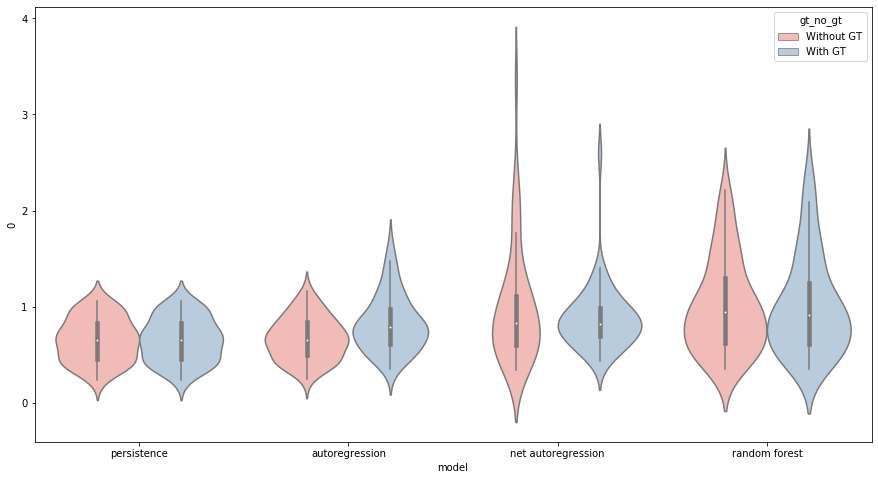

In [140]:
plt.figure(figsize = [15, 8])
sns.violinplot(x="model", y=0, hue="gt_no_gt", data=rmse_df, palette="Pastel1");